<a href="https://colab.research.google.com/github/vahterovua/codespaces-jupyter/blob/main/%D1%8F%D0%BD%D0%B4%D0%B5%D0%BA%D1%81_%D0%BF%D1%80%D0%B0%D0%BA%D1%82_%D1%81%D0%B5%D0%BA%D1%80%D0%B5%D1%82%D1%8B_%D1%82%D0%B5%D0%BC%D0%BD%D0%BE%D0%BB%D0%B5%D1%81%D1%8C%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [172]:
from sqlalchemy import create_engine
import pandas as pd

# Переменные для подключения
USERNAME = "praktikum_student"
PASSWORD = "Sdf4$2;d-d30pp"
HOST = "rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net"
DATABASE_NAME = "data-analyst-fantasy"
PORT = "6432"  # Номер порта, замените на фактический

# Форматируем строку подключения к PostgreSQL с указанным портом
connection_string = f"postgresql+psycopg2://{USERNAME}:{PASSWORD}@{HOST}:{PORT}/{DATABASE_NAME}"

# Создание engine объекта
engine = create_engine(connection_string)


In [173]:
print('1.1 доля платящих игроков')

q1 = """ SELECT
COUNT(id) AS общ_кол_во_игроков,
SUM(payer) AS кол_во_платящих_игроков,
ROUND(AVG(payer), 4) AS доля_платящих_игроков FROM fantasy.users WHERE payer IN (0, 1)"""

df1 = pd.read_sql_query(q1, con=engine)
df1

1.1 доля платящих игроков


,общ_кол_во_игроков,кол_во_платящих_игроков,доля_платящих_игроков
0,22214,3929,0.1769


In [174]:
print('1.1 доля платящих в разрезе расы')

q2="""select
r.race as раса,
sum(u.payer) as кол_во_платящих_игроков,
count(u.id) as общ_кол_во_игроков,
round(sum(u.payer)/count(u.id)::numeric,4) as доля_платящих_игроков_по_расе
from fantasy.race as r
join fantasy.users as u on r.race_id=u.race_id
group by r.race
order by доля_платящих_игроков_по_расе desc"""

df2=  pd.read_sql_query(q2, con=engine)
df2

1.1 доля платящих в разрезе расы


,раса,кол_во_платящих_игроков,общ_кол_во_игроков,доля_платящих_игроков_по_расе
0,Demon,238,1229,0.1937
1,Hobbit,659,3648,0.1806
2,Human,1114,6328,0.1760
3,Orc,636,3619,0.1757
4,Northman,626,3562,0.1757
5,Angel,229,1327,0.1726
6,Elf,427,2501,0.1707


<Axes: xlabel='раса'>

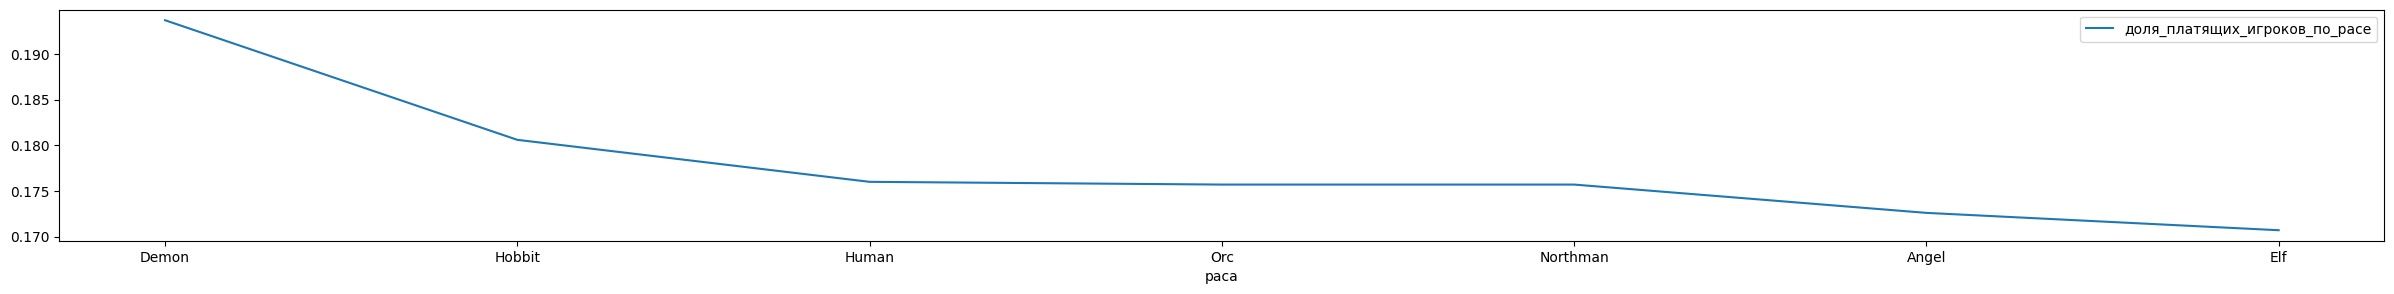

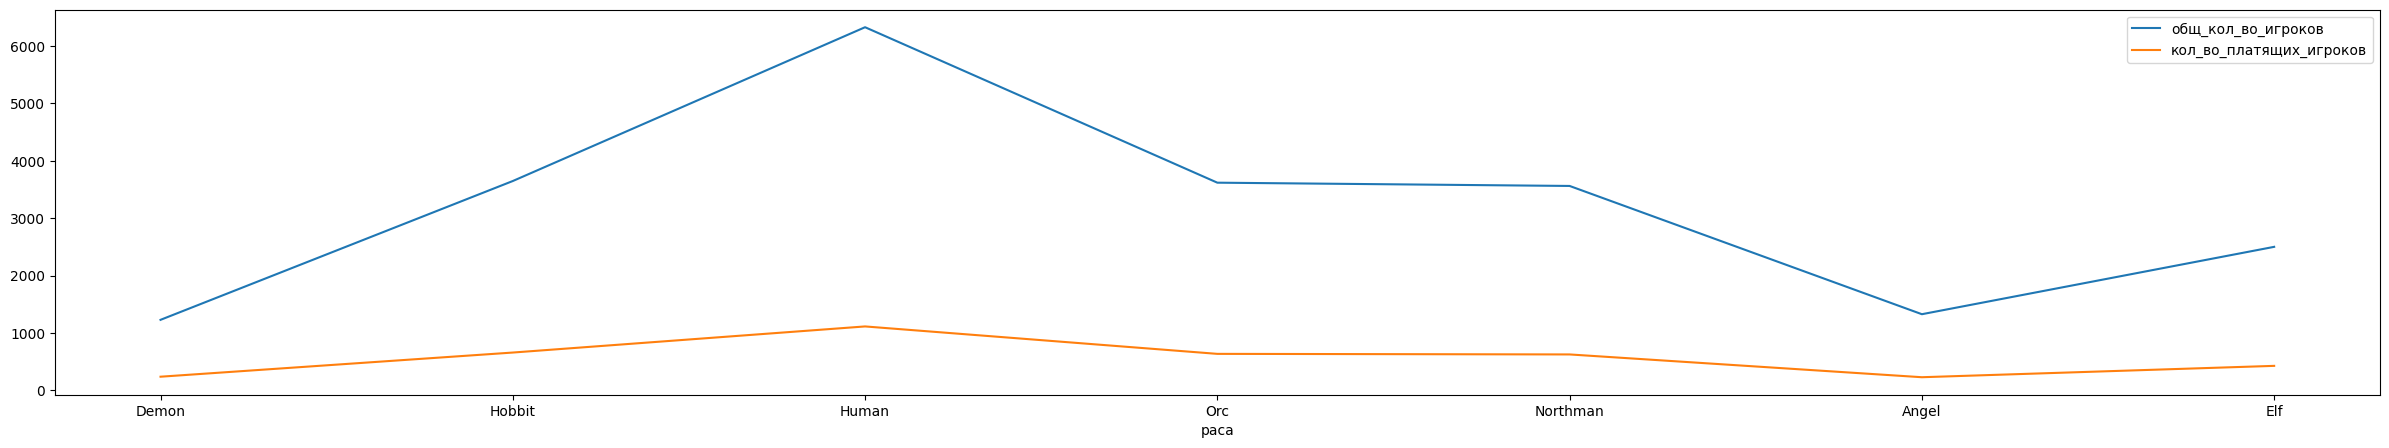

In [175]:
df2.plot(x='раса', y='доля_платящих_игроков_по_расе',figsize=(30,3))
df2.plot(x='раса', y=['общ_кол_во_игроков','кол_во_платящих_игроков'],figsize=(30,5))

In [176]:
print('2.1. Статистические показатели по полю amount')
q3="""select
'все_покупки' as категория,
count(transaction_id) as общ_кол_во_покупок,
sum(amount) as сумма_всех_покупок,
min(amount) as мин_стоимость_покупки,
max(amount) as max_стоимость_покупки,
avg(amount) as средн_стоимость_покупки,
PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY amount) as медианная_стоимость,
STDDEV(amount) AS стандарт_отклонение_стоимости
from fantasy.events
UNION
select
'без_покупок_с_нулевой_стоимостью'as категория,
count(transaction_id) as общ_кол_во_покупок,
sum(amount) as сумма_всех_покупок,
min(amount) as мин_стоимость_покупки,
max(amount) as max_стоимость_покупки,
avg(amount) as средн_стоимость_покупки,
PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY amount) as медианная_стоимость,
STDDEV(amount) AS стандарт_отклонение_стоимости
from fantasy.events
WHERE amount <> 0"""
df3=pd.read_sql_query(q3,con=engine)
df3

2.1. Статистические показатели по полю amount


,категория,общ_кол_во_покупок,сумма_всех_покупок,мин_стоимость_покупки,max_стоимость_покупки,средн_стоимость_покупки,медианная_стоимость,стандарт_отклонение_стоимости
0,без_покупок_с_нулевой_стоимостью,1306771,686615040.0,0.01,486615.1,526.056837,74.860001,2518.180798
1,все_покупки,1307678,686615040.0,0.00,486615.1,525.691966,74.860001,2517.345444


In [177]:
print('2.3 Сравнительный анализ активности платящих и неплатящих игроков')
q4="""with
t as (select
  case when u.payer=0 then 'не_платящий' else 'платящий'end as категория_игрока,
  count(distinct u.id) as количество_игроков_в_категории,
  count(e.transaction_id) as общ_кол_во_покупок,
  sum(e.amount) as общ_стоимоcть_покупок
from fantasy.users as u
join fantasy.events as e on u.id=e.id
where amount<>0
group by u.payer)
select
  категория_игрока,
  количество_игроков_в_категории,
  общ_кол_во_покупок/количество_игроков_в_категории::numeric as ср_кол_во_покупок_на_1го_игрока,
  общ_стоимоcть_покупок/количество_игроков_в_категории::numeric as ср_сум_стоимость_на_1го_игрока
from t;"""
df4=pd.read_sql_query(q4,con=engine)
df4

2.3 Сравнительный анализ активности платящих и неплатящих игроков


,категория_игрока,количество_игроков_в_категории,ср_кол_во_покупок_на_1го_игрока,ср_сум_стоимость_на_1го_игрока
0,не_платящий,11348,97.563007,48588.469510
1,платящий,2444,81.680033,55467.594108


In [178]:
print('2.4 популярные эпические предметы')
q5="""
with
t1 as (
    select count(distinct e.id) AS общ_кол_во_игроков
    from fantasy.events as e
),
t2 as (
    select i.game_items as эпик_предмет,
           e.transaction_id,
           e.id,
           i.item_code
    from fantasy.events AS e
    inner join fantasy.items as i on e.item_code = i.item_code
    where e.amount <> 0
),
t3 as (
    select эпик_предмет,
           count(*) as кол_во_покупок_по_предмету,
           count(*) * 1.0 / sum(count(*)) over () as доля_игроков_совершивших_покупки,
           count(distinct id) as кол_во_платящих_игроков
    from t2
    group by эпик_предмет
)

select
    эпик_предмет,
    кол_во_покупок_по_предмету,
    доля_игроков_совершивших_покупки,
    кол_во_платящих_игроков::numeric / (select общ_кол_во_игроков from t1) as доля_игроков_купивших_более_1раза
from t3
order by доля_игроков_купивших_более_1раза desc;
"""
df5=pd.read_sql_query(q5,con=engine)
df5

2.4 популярные эпические предметы


,эпик_предмет,кол_во_покупок_по_предмету,доля_игроков_совершивших_покупки,доля_игроков_купивших_более_1раза
0,Book of Legends,1004516,7.687009e-01,0.884072
1,Bag of Holding,271875,2.080510e-01,0.867687
2,Necklace of Wisdom,13828,1.058181e-02,0.117958
3,Gems of Insight,3833,2.933184e-03,0.067136
4,Treasure Map,3183,2.435775e-03,0.059378
...,...,...,...,...
139,Werewolf Fur,1,7.652450e-07,0.000073
140,Bow of Precision,1,7.652450e-07,0.000073
141,Monk's Prayer Beads,1,7.652450e-07,0.000073
142,Minotaur Horn,1,7.652450e-07,0.000073


In [179]:
print('ad hoc-Задача 1. Зависимость активности игроков от расы персонажа')
q6="""
with
t1--таблица для каждой расы общее количество зарегистрированных игроков
as
(select
    r.race as раса,
    count(distinct u.id) as кол_во_игроков_по_расе
    from fantasy.race as r
    join fantasy.users as u on r.race_id=u.race_id
    group by r.race),
t2 --таблица для каждой расы количество игроков, которые совершили покупку, и долю платящих игроков среди них
as
(select
    r.race as раса,
    count(distinct e.id) as кол_во_игроков_совершивших_покупки
    from fantasy.events as e
    join fantasy.users as u on e.id=u.id
    join fantasy.race as r on u.race_id=r.race_id
    where e.amount>0
    group by r.race),
t3 -- таблица для каждой расы подсчет платящих игроков
as (select
    r.race as раса,
    count(distinct e.id) as кол_во_платящих_игроков
    from fantasy.race as r
    join fantasy.users as u on r.race_id=u.race_id
    join fantasy.events as e on e.id=u.id
    where e.amount>0 and u.payer=1
    group by r.race),
t4 -- таблица активности игроков для каждой расы
as
(select
    r.race as раса,
    count(e.transaction_id)/count(distinct e.id)::float as ср_кол_во_покупок_на_1игрока,
    sum(e.amount)/count(distinct e.id)::float as ср_стоимость_покупки_на_1игрока,
    avg(amount) as ср_сум_стоимость_на1игрока
    from fantasy.events as e
    join fantasy.users as u on e.id=u.id
    join fantasy.race as r on u.race_id=r.race_id
    where e.amount<>0
    group by r.race)
-- соединяем все таблицы по полю раса
select
    t1.раса,
    t1.кол_во_игроков_по_расе,
    t2.кол_во_игроков_совершивших_покупки,
    t2.кол_во_игроков_совершивших_покупки/t1.кол_во_игроков_по_расе::float as доля_игроков_совершивших_покупки,
    t3.кол_во_платящих_игроков,
    t3.кол_во_платящих_игроков/t2.кол_во_игроков_совершивших_покупки::float as доля_платящих_игроков,
    t4.ср_кол_во_покупок_на_1игрока,
    t4.ср_стоимость_покупки_на_1игрока,
    t4.ср_сум_стоимость_на1игрока
from t1
join t2 on t1.раса=t2.раса
join t3 on t1.раса=t3.раса
join t4 on t1.раса=t4.раса
order by кол_во_игроков_по_расе desc
"""
df6=pd.read_sql_query(q6,con=engine)
df6

ad hoc-Задача 1. Зависимость активности игроков от расы персонажа


,раса,кол_во_игроков_по_расе,кол_во_игроков_совершивших_покупк,доля_игроков_совершивших_покупки,кол_во_платящих_игроков,доля_платящих_игроков,ср_кол_во_покупок_на_1игрока,ср_стоимость_покупки_на_1игрока,ср_сум_стоимость_на1игрока
0,Human,6328,3921,0.619627,706,0.180056,121.402193,48933.194593,403.130797
1,Hobbit,3648,2266,0.621162,401,0.176964,86.128861,47622.068844,552.903146
2,Orc,3619,2276,0.628903,396,0.173989,81.738137,41762.175747,510.900256
3,Northman,3562,2229,0.625772,406,0.182144,82.101839,62518.977120,761.501218
4,Elf,2501,1543,0.616953,251,0.162670,78.790668,53762.374595,682.334772
5,Angel,1327,820,0.617935,137,0.167073,106.804878,48665.960976,455.678166
6,Demon,1229,737,0.599675,147,0.199457,77.869742,41194.208955,529.055074


In [180]:
print('ad hoc Задача 2 Частота покупок')
q7="""
WITH
t1 --для каждой покупки посчитайте количество дней с предыдущей покупки — это позволит получить количество дней между покупками
AS (
    SELECT
        e.transaction_id,
        e.id,
        e.date::DATE AS purchase_date,
        LAG(e.date::DATE) OVER (PARTITION BY e.id ORDER BY e.date::DATE) AS prev_purchase_date,
        e.date::DATE - LAG(e.date::DATE) OVER (PARTITION BY e.id ORDER BY e.date::DATE) AS кол_во_дней_между_покупками
    FROM fantasy.events e
    WHERE e.amount > 0
),
t2--количество покупок на одного игрока и сред кол-во дней между покупками для игроков у которых более 25 покупок
AS (
    SELECT
        t1.id,
        COUNT(t1.transaction_id) AS total_purchases,
        AVG(t1.кол_во_дней_между_покупками)::NUMERIC(8,2) AS avg_days_between_purchases
    FROM t1
    GROUP BY t1.id
    HAVING COUNT(t1.transaction_id) >= 25
),
t3--присвоим ранги для игроков
AS (
    SELECT
        *,
        NTILE(3) OVER (ORDER BY t2.avg_days_between_purchases ASC) AS frequency_group,
        CASE
            WHEN NTILE(3) OVER (ORDER BY t2.avg_days_between_purchases ASC) = 1 THEN 'Высокая частота'
            WHEN NTILE(3) OVER (ORDER BY t2.avg_days_between_purchases ASC) = 2 THEN 'Средняя частота'
            ELSE 'Низкая частота'
        END AS категория_игроков
    FROM t2
),
t4--final_aggregation
AS (
    SELECT
        t3.категория_игроков,
        SUM(CASE WHEN u.payer = 1 THEN 1 ELSE 0 END) AS кол_во_платящих_игроков,
        COUNT(*) AS кол_во_игроков_в_категории,
        ROUND(AVG(t3.total_purchases)::NUMERIC, 2) AS ср_кол_во_покупок_на_1игрока,
        ROUND(AVG(t3.avg_days_between_purchases)::NUMERIC, 2) AS ср_кол_во_дней_между_покупками
    FROM t3
    LEFT JOIN fantasy.users u ON t3.id = u.id
    GROUP BY t3.категория_игроков
)
SELECT*,
кол_во_платящих_игроков/кол_во_игроков_в_категории::float as доля_платящих_игроков
FROM t4
ORDER BY ср_кол_во_покупок_на_1игрока DESC;
"""
df7=pd.read_sql_query(q7,con=engine)
df7


ad hoc Задача 2 Частота покупок


,категория_игроков,кол_во_платящих_игроков,кол_во_игроков_в_категории,ср_кол_во_покупок_на_1игрока,ср_кол_во_дней_между_покупками,доля_платящих_игроков
0,Высокая частота,472,2572,390.66,3.29,0.183515
1,Средняя частота,451,2572,58.81,7.54,0.175350
2,Низкая частота,434,2572,33.64,13.29,0.168740


<Axes: xlabel='доля_платящих_игроков'>

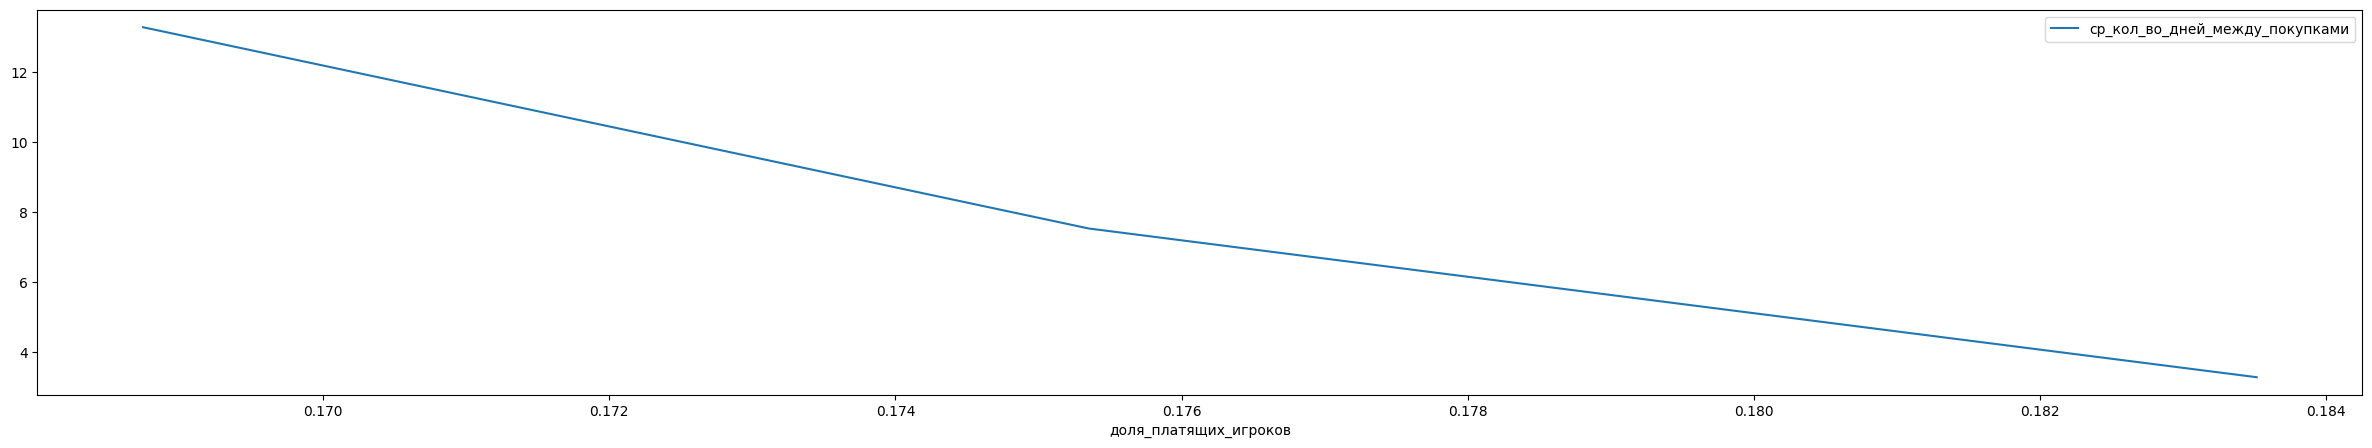

In [181]:
df7.plot(x='доля_платящих_игроков',y='ср_кол_во_дней_между_покупками',figsize=(30,5))

In [182]:
# Завершаем сессию
engine.dispose()

In [197]:
from sqlalchemy import create_engine
import pandas as pd

# запрос-
q="""
select*
from fantasy.items
--where item_code=6010
limit 5
"""

# Переменные для подключения
USERNAME = "praktikum_student"
PASSWORD = "Sdf4$2;d-d30pp"
HOST = "rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net"
DATABASE_NAME = "data-analyst-fantasy"
PORT = "6432"  # Номер порта

# Форматируем строку подключения к PostgreSQL с указанным портом
connection_string = f"postgresql+psycopg2://{USERNAME}:{PASSWORD}@{HOST}:{PORT}/{DATABASE_NAME}"

# Создание engine объекта
engine = create_engine(connection_string)


a=pd.read_sql_query(q,con=engine)

# Завершаем сессию
engine.dispose()
a


,item_code,game_items
0,9402,Ranger's Bow
1,9399,Paladin's Hammer
2,9311,Knight's Shield
3,9222,Monk's Prayer Beads
4,9211,Bard's Lute
